## High-dynamic range imaging - The Debevec-Malik method
#### April Li, Mesha Naidoo-Edwardson
#### s826li@uwaterloo.ca, mnaidooe@uwaterloo.ca

The goal of this project is to implement the high-dynamic range imaging (HDRI). HDRI is a method in photography that combines multiple exposures of the same subject matter with varying exposure levels to create more natural looking and brightened images. HDRI as a topic has several different algorithms. In this project, we will utilize the Debevec-Malik algorithm, published at UC Berekeley by Paul E. Debevec and Jitendra Malik. The algorithm is a method to recover high dynamic range radiance maps from images taken using convential imaging equipment. Using information from all the images, it fuses multiple photographs into a signle, high dynamic range radiance map. The pixels in the map have values proportional to true radiance values in the scene. 

Our goal is to separate the algorithm into easily digestable steps that make it simple to understand how the results are achieved. We will use a variety of examples to show the end result and compare our implementation against one by OpenCV, exploring any potential differences and reason about where they may originate.

## Team Members and Contributions
April Li (s826li@uwaterloo.ca):

Mesha Naidoo-Edwardson (mnaidooe@uwaterloo.ca):

### Code Libraries
- Numpy: Providing mathematical capabilities in python
- matplotlib.pyplot: Helpful graphing features
- matplotlib.image: Import images
- os: Access files
- random: Helping with sampling

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import os
import random

Arch photos By Kevin McCoy - Own work, CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=7672643

### Step 1

### Importing Images and Data, declare Constants
The first step in our process is to load images and exposure times. These images are to have been taken from the same vantage point, and have different **known** exposure durations $\delta t_j$. The images will be loaded as 3-channel RGB values. For now this information isn't too important, but we will remember this down the line as we will need to run our computations on each of the channels to obtain our final result.

In [15]:
# Load into an array of images (4D)
def load_images(path):
    images = []

    for file in sorted(os.listdir(path)):
        if file.startswith(path) and (file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg')):
            image_path = os.path.join(path, file)
            img = (image.imread(image_path) * 255).astype(int)
            images.append(img)
    return np.stack(images)

In [16]:
# Load into a 1D array of exposure times
def load_exposure_times(path):
    file_path = f'{path}/{path}.txt'
    with open(file_path, 'r') as f:
        exposure_times_str = f.readlines()
    
    # Convert the exposure time strings to numerical values
    exposure_times = []
    for time_str in exposure_times_str:
        # Assuming the format is "1/xxx"
        numerator, denominator = time_str.strip().split('/')
        exposure_times.append(float(numerator) / float(denominator))
    
    return np.array(exposure_times)

In [17]:
## Specify which test images to use
PATH="arch"
images = load_images(PATH)
exposure_times = load_exposure_times(PATH)

### Weighting Function
In order to emphasize the smoothness and fitting terms toward the middle of the curve, Debevec defines the following weighting function:

$$w(z) =
\begin{cases}
    z - Z_{min}\quad \text{for } z \leq \frac{1}{2}(Z_{min} + Z_{max})\\
    Z_{max} - z\quad \text{for } z > \frac{1}{2}(Z_{min} + Z_{max})\\
\end{cases}$$

In our case, zMin will be 0 and zMax 255, representing the possible pixel values.

In [18]:
def w(z):
    zMin, zMax = 0., 255.
    if z <= (zMin + zMax) / 2:
        return z - zMin
    return zMax - z

In order to solve, we don't need to use every available pixel site in the solution procedure. Given $N$ pixels in $P$ photographs, our goal is solving for $N$ values of $

In [19]:
def sampleIntensities(images):  
    zMin, zMax = 0, 255
    n = zMax - zMin + 1
    num_images = len(images)
    values = np.zeros((n, num_images), dtype=np.uint8)

    mid = images[num_images // 2]

    for i in range(zMin, zMax + 1):
        rows, cols = np.where(mid == i)
        if len(rows) != 0:
            idx = random.randrange(len(rows))
            for j in range(num_images):
                values[i, j] = images[j][rows[idx], cols[idx]]
    return values

In [20]:
def gSolve(Z, B, l=100, w=w):
    n = 256
    m = Z.shape[0] * Z.shape[1] + n + 1
    A = np.zeros((m, n + Z.shape[0]))
    b = np.zeros((m, 1))

    k = 0
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            zij = Z[i, j]
            wij = w(zij)
            A[k, zij] = wij
            A[k, n + i] = -wij
            b[k, 0] = wij * B[j]
            k += 1

    A[k, 128] = 1
    k += 1

    for i in range(n - 2):
        A[k, i] = l * w(i + 1)
        A[k, i + 1] = -2 * l * w(i + 1)
        A[k, i + 2] = l * w(i + 1)
        k += 1

    x = np.linalg.lstsq(A, b, rcond=None)[0]
    g = x[:n]
    lE = x[n:n + Z.shape[0]]

    return g, lE

In [21]:
%%time

def computeRadianceMap(images, log_exposure_times, response_curve, weighting_function=w):
    num_images = len(images)
    img_shape = images[0].shape

    # Precompute response for all images
    response = np.empty((num_images, img_shape[0], img_shape[1]))
    for i, img_set in enumerate(images):
        for j in range(img_shape[0]):
            for k in range(img_shape[1]):
                response[i, j, k] = response_curve[img_set[j, k]]

    # Apply the weighting function to each image
    weights = np.empty_like(response)
    for i, img_set in enumerate(images):
        for j in range(img_shape[0]):
            for k in range(img_shape[1]):
                weights[i, j, k] = weighting_function(img_set[j, k])

    # Sum of weights across all images
    sum_weights = np.sum(weights, axis=0)

    # Avoid division by zero
    sum_weights[sum_weights == 0] = 1

    # Reshape log_exposure_times for broadcasting
    log_exposure_times_reshaped = log_exposure_times.reshape(num_images, 1, 1)

    # Compute weighted radiance map
    img_rad_map = np.sum(weights * (response - log_exposure_times_reshaped), axis=0) / sum_weights

    # Handle zero weights by using the median image's response value
    zero_weights_mask = sum_weights == 1
    median_response = response[num_images // 2]
    img_rad_map[zero_weights_mask] = median_response[zero_weights_mask] - log_exposure_times[num_images // 2]

    return img_rad_map

CPU times: user 10 µs, sys: 2 µs, total: 12 µs
Wall time: 18.4 µs


In [22]:
# Select each of the three colour channels (RGB)
R = images[:,:,:,0]
G = images[:,:,:,1]
B = images[:,:,:,2]

In [23]:
# Randomly sample intensities from these channels
sampleRed = sampleIntensities(R)
sampleGreen = sampleIntensities(G)
sampleBlue = sampleIntensities(B)

In [24]:
# Calculate the logarithm of the exposure times
logExposures = np.log(exposure_times)

# Solve the least-squares equation
gr, lEr = gSolve(sampleRed, logExposures)
gg, lEg = gSolve(sampleGreen, logExposures)
gb, lEb = gSolve(sampleBlue, logExposures)

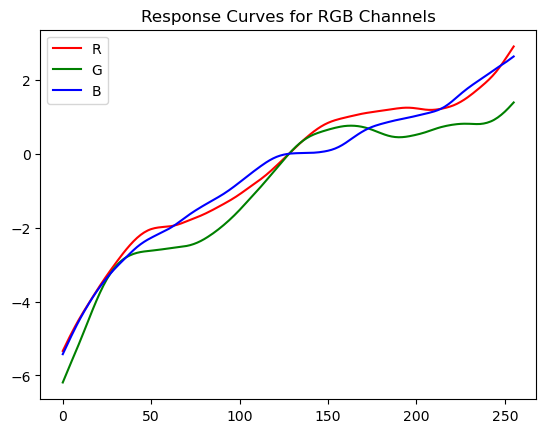

In [25]:
plt.title("Response Curves for RGB Channels")
plt.plot(gr, color="red", label="R")
plt.plot(gg, color="green", label="G")
plt.plot(gb, color="blue", label="B")
plt.legend()

In [26]:
# Compute Radiance Map for each of our channels
mapR = computeRadianceMap(R, logExposures, gr)
mapG = computeRadianceMap(G, logExposures, gg)
mapB = computeRadianceMap(B, logExposures, gb)

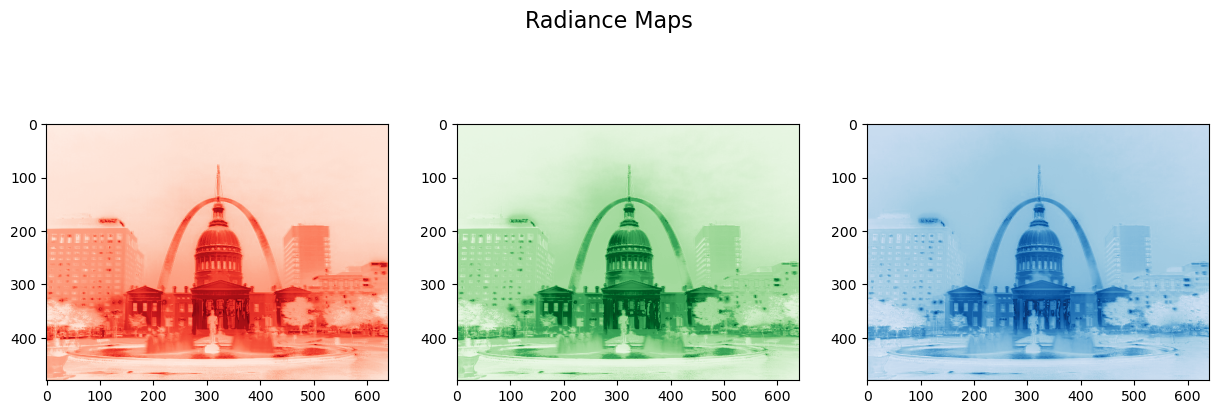

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

fig.suptitle("Radiance Maps", fontsize=16)
axs[0].imshow(mapR, cmap="Reds")
axs[1].imshow(mapG, cmap="Greens")
axs[2].imshow(mapB, cmap="Blues")

In [28]:
hdr_image = np.zeros(images[0].shape, dtype=int)

# Normalize the values in our maps
mn, mx = mapR.min(), mapR.max()
normalized_mapR = (((mapR - mn) * 256) / (mx - mn)).astype(np.uint8) 

mn, mx= mapG.min(), mapG.max()
normalized_mapG = (((mapG - mn) * 256) / (mx - mn)).astype(np.uint8) 

mn, mx = mapB.min(), mapB.max()
normalized_mapB = (((mapB - mn) * 256) / (mx - mn)).astype(np.uint8)

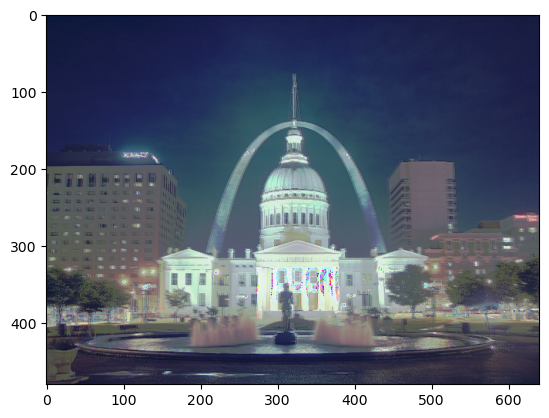

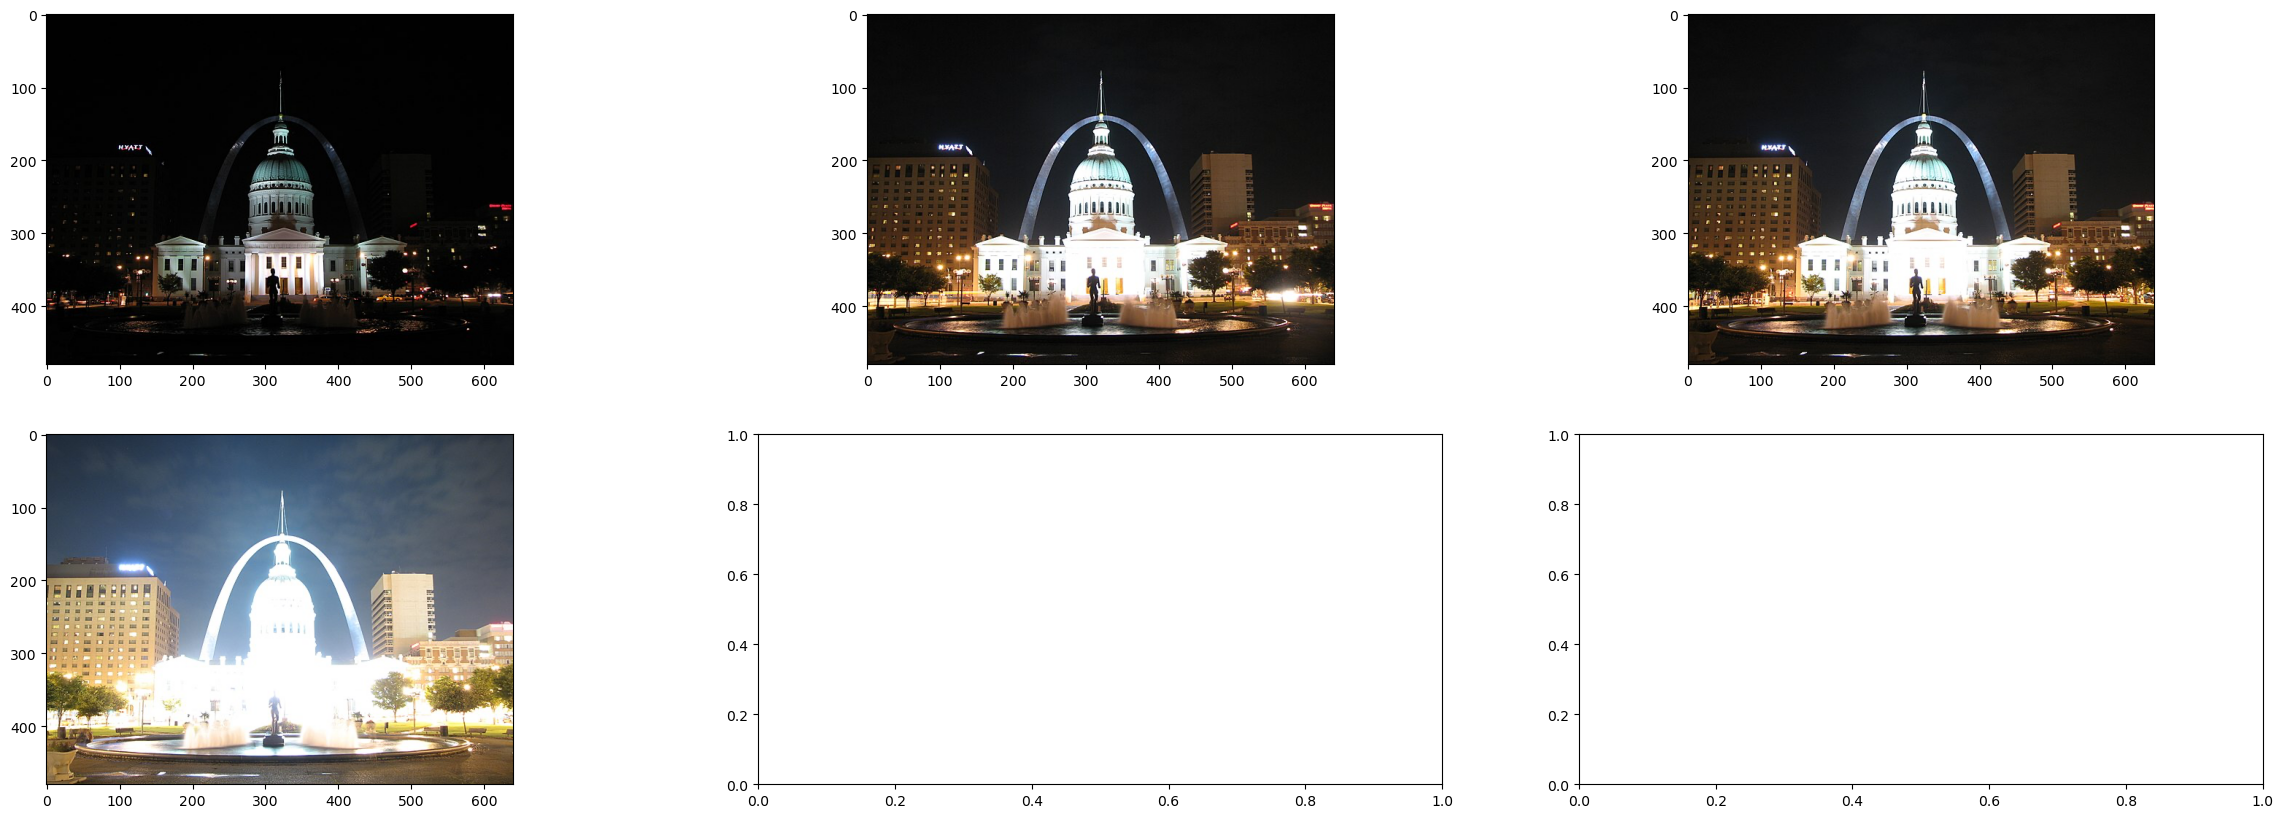

In [29]:
# Combine back into one HDR image
hdr_image[..., 0] = normalized_mapR
hdr_image[..., 1] = normalized_mapG
hdr_image[..., 2] = normalized_mapB

plt.imshow(hdr_image)
fig, axs = plt.subplots(2, 3, figsize=(30, 10))
axs[0][0].imshow(images[0])
axs[0][1].imshow(images[1])
axs[0][2].imshow(images[2])
axs[1][0].imshow(images[3])
# axs[1][1].imshow(images[4])
# axs[1][2].imshow(images[5])

### Conclusions
..........